In [1]:
#import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from xgboost import plot_importance
from xgboost import plot_tree
import graphviz
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import itertools

In [77]:
data = pd.read_csv("PELNE DANE.csv", delimiter=";", decimal=",")

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 26 columns):
Gatunek    3029 non-null object
KOL        3029 non-null object
APZ        152 non-null float64
APW        147 non-null float64
D1         451 non-null float64
D2         452 non-null float64
PS         439 non-null float64
R          2519 non-null float64
SC         424 non-null float64
PL         2570 non-null float64
PYL        2564 non-null float64
K-J        2725 non-null float64
PYLZN      2212 non-null float64
PYLPL      2528 non-null float64
ZN         453 non-null float64
SZY        339 non-null float64
NB         249 non-null float64
KAT        278 non-null float64
V          505 non-null float64
KON        572 non-null float64
MASA       477 non-null float64
POW        948 non-null float64
NAS        793 non-null float64
WYS        793 non-null float64
SZER       793 non-null float64
SZEW       606 non-null float64
dtypes: float64(24), object(2)
memory usage: 615.3+ KB


In [79]:
#retruns pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "INS"

In [80]:
data['Pollinator'] = data['Gatunek'].apply(pollinator)

In [81]:
col = {'INS':'#FFE125', 'PAS':'#007800', 'FLY':"#e5247e", 'HUM':'#bf0000'}

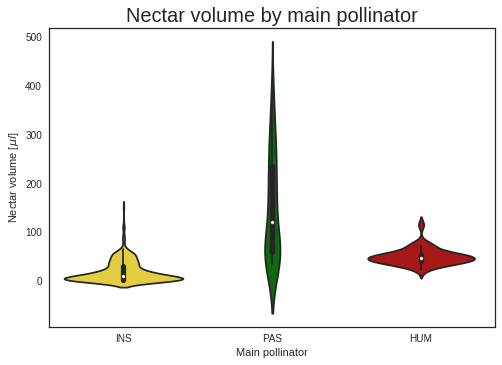

In [82]:
sns.violinplot(x="Pollinator", y ="V", data=data, palette=col)
sns.set_style("white")
plt.title("Nectar volume by main pollinator", fontsize=20)
plt.ylabel(r'Nectar volume [$\mu l$]')
plt.xlabel("Main pollinator")
plt.savefig('Vol.jpg', bbox_inches="tight", dpi=1000)
plt.show()

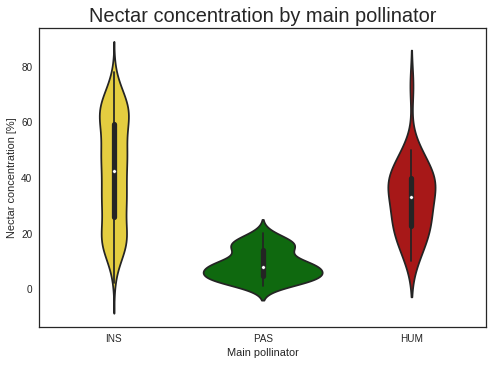

In [83]:
sns.violinplot(x="Pollinator", y ="KON", data=data, palette=col)
sns.set_style("white")
plt.title("Nectar concentration by main pollinator", fontsize=20)
plt.ylabel(r'Nectar concentration [%]')
plt.xlabel("Main pollinator")
plt.savefig('kon.jpg', bbox_inches="tight", dpi=1000)
plt.show()

In [84]:
amino = pd.read_csv("aminokwasy.csv")

In [85]:
amino["Total"] = amino.iloc[:,3:33].sum(axis = 1)

In [86]:
amino["Pollinator"] = amino["Gatunek"].apply(pollinator)

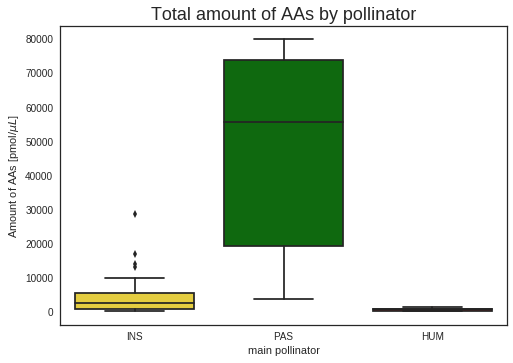

In [87]:
sns.boxplot(data=amino, x='Pollinator', y='Total', 
           palette=col)
plt.xlabel("main pollinator")
plt.ylabel("Amount of AAs [pmol/$\mu L$]")
plt.title("Total amount of AAs by pollinator", fontsize=18)
plt.savefig('aa.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

In [89]:
df = data.groupby(['Gatunek']).agg({'V': 'mean', 'KON': 'mean', 
                                    'MASA':'mean'}).reset_index()

In [90]:
df.head()

,Gatunek,V,KON,MASA
0,F. acmopetala,40.303615,36.1800,0.013834
1,F. affinis,15.400000,13.0000,NaN
2,F. amabilis,NaN,NaN,NaN
3,F. amana,13.350000,47.8125,0.004443
4,F. argolica,NaN,NaN,NaN


In [65]:
df['Pollinator'] = df['Gatunek'].apply(pollinator)

In [66]:
df.dropna(inplace=True)

In [67]:
df

,Gatunek,V,KON,MASA,Pollinator
0,F. acmopetala,40.303615,36.180000,0.013834,INS
3,F. amana,13.350000,47.812500,0.004443,INS
6,F. assyriaca,7.800000,47.812500,0.003756,INS
11,F. bucharica,0.302500,52.650000,0.000248,INS
13,F. carica,12.740000,23.283277,0.013419,INS
14,F. caucasica,1.400000,28.300000,0.005030,INS
18,F. drenovskii,35.785714,29.071429,0.012207,INS
19,F. eastwoodiae,33.833333,16.333333,0.009587,INS
20,F. eduardii,56.529412,5.035000,0.025752,PAS
24,F. gentneri,51.897054,31.880624,0.061813,HUM


In [18]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets 
import numpy as np
from scipy import special

In [19]:
data.head()

,Gatunek,KOL,APZ,APW,D1,D2,PS,R,SC,PL,...,KAT,V,KON,MASA,POW,NAS,WYS,SZER,SZEW,Pollinator
0,F. acmopetala,1,9.0,4.0,40.95,42.18,27.58,0.813809,30.71,33.89,...,45.0,35.0,16.50,0.003784,14.0,4.0,10.5,3.5,2.0,INS
1,F. acmopetala,1,17.0,2.0,44.74,39.21,26.61,0.785187,32.68,33.89,...,NaN,24.0,35.25,0.003021,15.0,5.0,6.5,3.5,1.8,INS
2,F. acmopetala,1,9.0,0.0,44.93,44.77,28.71,0.916667,46.90,31.32,...,NaN,NaN,NaN,NaN,25.8,5.0,8.0,3.0,1.2,INS
3,F. acmopetala,1,9.0,NaN,40.39,40.62,24.05,0.742513,48.83,32.39,...,NaN,NaN,NaN,NaN,31.4,2.5,9.0,3.0,1.3,INS
4,F. acmopetala,1,9.0,NaN,42.61,42.85,26.79,0.750000,56.60,35.72,...,NaN,40.0,21.00,0.003113,19.1,4.0,8.5,3.0,1.5,INS


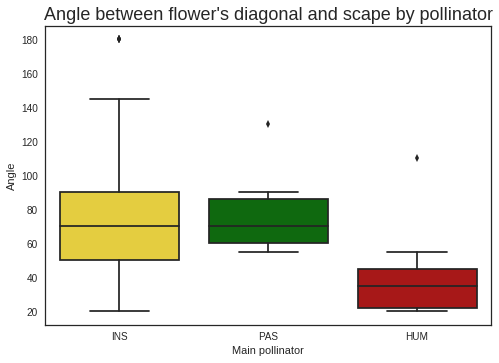

In [91]:
sns.boxplot(data=data, x='Pollinator', y='KAT', 
           palette=col)
plt.xlabel("Main pollinator")
plt.ylabel("Angle")
plt.title("Angle between flower's diagonal and scape by pollinator", fontsize=18)
plt.savefig('angle.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

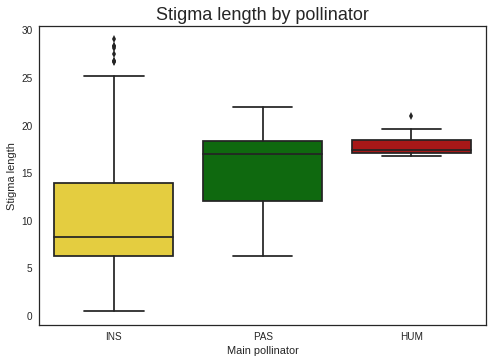

In [92]:
sns.boxplot(data=data, x='Pollinator', y='SZY', 
           palette=col)
plt.xlabel("Main pollinator")
plt.ylabel("Stigma length")
plt.title("Stigma length by pollinator", fontsize=18)
plt.savefig('stigma.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

In [93]:
data["stosunek"] = data["PYL"] / data["PL"]

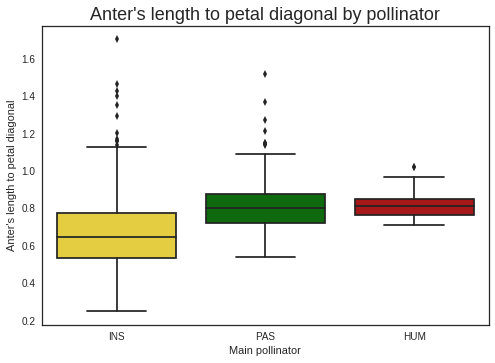

In [94]:
sns.boxplot(data=data, x='Pollinator', y='stosunek', 
           palette=col)
plt.xlabel("Main pollinator")
plt.ylabel("Anter's length to petal diagonal")
plt.title("Anter's length to petal diagonal by pollinator", fontsize=18)
plt.savefig('stosunek.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

In [29]:
data.iloc[:,5:].head()

,D2,PS,R,SC,PL,PYL,K-J,PYLZN,PYLPL,ZN,...,V,KON,MASA,POW,NAS,WYS,SZER,SZEW,Pollinator,stosunek
0,42.18,27.58,0.813809,30.71,33.89,28.63,-5.26,1.71,8.36,23.81,...,35.0,16.50,0.003784,14.0,4.0,10.5,3.5,2.0,INS,0.844792
1,39.21,26.61,0.785187,32.68,33.89,29.49,-4.40,1.62,8.31,NaN,...,24.0,35.25,0.003021,15.0,5.0,6.5,3.5,1.8,INS,0.870168
2,44.77,28.71,0.916667,46.90,31.32,28.61,-2.71,1.70,7.64,NaN,...,NaN,NaN,NaN,25.8,5.0,8.0,3.0,1.2,INS,0.913474
3,40.62,24.05,0.742513,48.83,32.39,27.85,-4.54,1.70,7.64,NaN,...,NaN,NaN,NaN,31.4,2.5,9.0,3.0,1.3,INS,0.859833
4,42.85,26.79,0.750000,56.60,35.72,27.85,-7.87,1.92,9.38,NaN,...,40.0,21.00,0.003113,19.1,4.0,8.5,3.0,1.5,INS,0.779675


In [32]:
data.Pollinator.unique()

array(['INS', 'PAS', 'HUM'], dtype=object)

In [95]:
ins_st = data.stosunek[data.Pollinator == "INS"]

In [96]:
pas_st = data.stosunek[data.Pollinator == "PAS"]
hum_st = data.stosunek[data.Pollinator == "HUM"]

In [97]:
pas_st.dropna(inplace=True)

In [98]:
hum_st.dropna(inplace=True)
ins_st.dropna(inplace=True)

In [40]:
from scipy import stats

In [41]:
stats.kruskal(ins_st, pas_st, hum_st)

KruskalResult(statistic=298.52334427697025, pvalue=1.5013412963642521e-65)

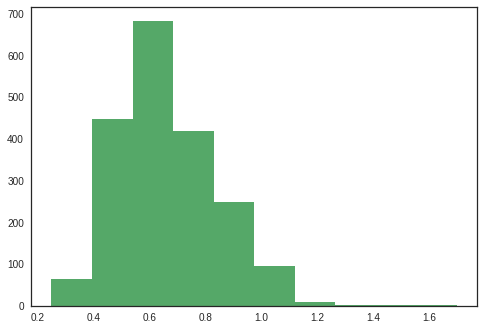

In [43]:
plt.hist(ins_st)
plt.show()

In [45]:
from statsmodels.stats.diagnostic import lillifors
data = ins_st
#fewData = fewData_t

pVals = pd.Series()
#pFewVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(data)
#_, pFewVals['Omnibus'] = stats.normaltest(fewData)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(data)
#_, pFewVals['Shapiro-Wilk'] = stats.shapiro(fewData)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(data)
#_, pFewVals['Lilliefors'] = lillifors(fewData)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
#_, pFewVals['Kolmogorov-Smirnov'] = stats.kstest((fewData-np.mean(fewData))/np.std(fewData,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(data)))
print(pVals)
#print('p-values for the first 100 data points: ----------------')
#print(pFewVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

p-values for all 1970 data points: ----------------
Omnibus               3.542302e-30
Shapiro-Wilk          1.710037e-17
Lilliefors            4.694580e-19
Kolmogorov-Smirnov    7.176284e-07
dtype: float64


In [46]:
#fewData = fewData_t
data = hum_st
pVals = pd.Series()
#pFewVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(data)
#_, pFewVals['Omnibus'] = stats.normaltest(fewData)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(data)
#_, pFewVals['Shapiro-Wilk'] = stats.shapiro(fewData)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(data)
#_, pFewVals['Lilliefors'] = lillifors(fewData)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
#_, pFewVals['Kolmogorov-Smirnov'] = stats.kstest((fewData-np.mean(fewData))/np.std(fewData,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(data)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

p-values for all 90 data points: ----------------
Omnibus               0.001868
Shapiro-Wilk          0.000916
Lilliefors            0.075247
Kolmogorov-Smirnov    0.453226
dtype: float64


In [47]:
data = pas_st
pVals = pd.Series()
#pFewVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(data)
#_, pFewVals['Omnibus'] = stats.normaltest(fewData)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(data)
#_, pFewVals['Shapiro-Wilk'] = stats.shapiro(fewData)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(data)
#_, pFewVals['Lilliefors'] = lillifors(fewData)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
#_, pFewVals['Kolmogorov-Smirnov'] = stats.kstest((fewData-np.mean(fewData))/np.std(fewData,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(data)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

p-values for all 328 data points: ----------------
Omnibus               1.684150e-21
Shapiro-Wilk          2.852308e-11
Lilliefors            9.351404e-04
Kolmogorov-Smirnov    9.230750e-02
dtype: float64


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from statsmodels.stats.libqsturng import psturng

In [49]:
# First, check if the variances are equal, with the "Levene"-test
(W,p) = stats.levene(ins_st, pas_st, hum_st)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))

In [51]:
f, p = stats.f_oneway(ins_st,
                      hum_st,
                      pas_st)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 131.686529163
P value: 5.65258960962e-55 



In [99]:
st = data[np.isfinite(data['stosunek'])]

In [100]:
#Then, do the multiple testing
multiComp = MultiComparison(st['stosunek'], st['Pollinator'])

In [101]:
print((multiComp.tukeyhsd().summary()))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 HUM    INS   -0.1551  -0.1976 -0.1125  True 
 HUM    PAS   -0.0104  -0.0573  0.0365 False 
 INS    PAS    0.1446   0.1211  0.1682  True 
---------------------------------------------
